In [1]:
import polars as pl
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load your dataset
df = pl.read_csv('./processed/final_aggregated_rides_example.csv')

# Convert 'Interval' to datetime
df = df.with_columns(
    pl.col("Interval").str.to_datetime().alias("Interval")
)

# Sort by Cluster and Interval
df = df.sort(["Cluster", "Interval"])

In [4]:
df = df.with_columns(
    pl.col("Interval").dt.weekday().alias("DayOfWeek")
)
df = df.with_columns(
    pl.col("Interval").dt.hour().alias("HourOfDay"),
    pl.col("Interval").dt.month().alias("Month"),
    pl.col("Interval").dt.ordinal_day().alias("DayOfYear")
)
df = df.with_columns(
    ((((pl.col("HourOfDay") >= 7) & (pl.col("HourOfDay") < 10) | ((pl.col("HourOfDay") >= 17) & (pl.col("HourOfDay") < 19))) & ((pl.col("DayOfWeek") >= 1) & (pl.col("DayOfWeek") <= 5))) |
     (((pl.col("HourOfDay") >= 13) & (pl.col("HourOfDay") <= 19)) & ((pl.col("DayOfWeek") >= 6) & (pl.col("DayOfWeek") <= 7)))
).cast(pl.Int8).alias("IsPeak"))

In [5]:
df_weather_data = pl.read_csv("./data/open-meteo-51.49N0.16W23m.csv")
df_weather_data = df_weather_data.with_columns(
    pl.col("time").str.to_datetime().alias("Interval")
)

df_weather_data = df_weather_data.drop(["time"])

df_half_hour = df_weather_data.with_columns(
    (pl.col("Interval") + pl.duration(minutes=30)).alias("Interval")
)

df_weather_data = (
    pl.concat([df_weather_data, df_half_hour])
    .sort("Interval")
)
df_weather_data = df_weather_data.filter(
    (pl.col("Interval").dt.year() >= 2018) & (pl.col("Interval").dt.year() <= 2019)
)
df_weather_data

temperature_2m (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),Interval
f64,f64,f64,f64,datetime[μs]
6.5,0.0,0.0,28.7,2018-01-01 00:00:00
6.5,0.0,0.0,28.7,2018-01-01 00:30:00
6.3,0.0,0.0,25.7,2018-01-01 01:00:00
6.3,0.0,0.0,25.7,2018-01-01 01:30:00
5.7,0.0,0.0,23.7,2018-01-01 02:00:00
…,…,…,…,…
7.0,0.0,0.0,13.7,2019-12-31 21:30:00
6.3,0.0,0.0,12.5,2019-12-31 22:00:00
6.3,0.0,0.0,12.5,2019-12-31 22:30:00


In [6]:
df = df.join(df_weather_data, on="Interval")

In [7]:
df_bank_holidays = pl.read_csv("./data/bank_holidays.csv")
df_bank_holidays = df_bank_holidays.with_columns(
    pl.col("Date").str.to_date().alias("Date")
)
bank_holiday_series = df_bank_holidays["Date"]
bank_holiday_series

Date
date
2017-01-02
2017-04-14
2017-04-17
2017-05-01
2017-05-29
…
2023-05-08
2023-05-29
2023-08-28


In [8]:
df = df.with_columns(
    (df["Interval"].dt.date().is_in(bank_holiday_series)).cast(pl.Int8).alias("Holiday")
)

In [9]:
df.head()

Cluster,Interval,Starts,Ends,DayOfWeek,HourOfDay,Month,DayOfYear,IsPeak,temperature_2m (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),Holiday
i64,datetime[μs],i64,i64,i8,i8,i8,i16,i8,f64,f64,f64,f64,i8
0,2018-01-01 00:00:00,16,7,1,0,1,1,0,6.5,0.0,0.0,28.7,1
0,2018-01-01 00:30:00,77,16,1,0,1,1,0,6.5,0.0,0.0,28.7,1
0,2018-01-01 01:00:00,29,15,1,1,1,1,0,6.3,0.0,0.0,25.7,1
0,2018-01-01 01:30:00,25,6,1,1,1,1,0,6.3,0.0,0.0,25.7,1
0,2018-01-01 02:00:00,10,5,1,2,1,1,0,5.7,0.0,0.0,23.7,1


In [10]:
def create_sequences_with_future_features(data, seq_length, pred_length):
    """
    Create sequences for multi-step forecasting with separate historical and future auxiliary features.
    
    Parameters:
    data: numpy array of shape (num_samples, num_features).
    seq_length: length of the historical input sequence.
    pred_length: number of steps to predict ahead.
    
    Returns:
    X_hist: Historical data including all features [num_samples, seq_length, num_features]
    X_aux: Future auxiliary features (excluding target features) [num_samples, pred_length, aux_features]
    y: Target values [num_samples, pred_length, 2]
    """
    xs, future_features, ys = [], [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        # Historical sequence (all features)
        x = data[i:(i + seq_length)]
        # Future auxiliary features (excluding target variables)
        future_feature = data[(i + seq_length):(i + seq_length + pred_length), 2:]  # All features except Starts and Ends
        # Target values (only Starts and Ends)
        y = data[(i + seq_length):(i + seq_length + pred_length), :2]
        xs.append(x)
        future_features.append(future_feature)
        ys.append(y)
    return np.array(xs), np.array(future_features), np.array(ys)


# Function to split data into training and validation sets
def train_val_split(data, train_ratio=0.8):
    """
    Split data into training and validation sets.
    data: numpy array of shape (num_samples, num_features).
    train_ratio: fraction of data to use for training.
    """
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:]
    return train_data, val_data

# Prepare data for each cluster
seq_length = 7 * 48  # 7 days * 48 half-hour intervals per day
pred_length = 48  # Predict 24 steps (12 hours) ahead
train_ratio = 0.8  # 80% training, 20% validation

clusters_train_data = {}
clusters_val_data = {}
scalers = {}

for cluster in df["Cluster"].unique():
    # Select relevant columns: Starts, Ends, DayOfWeek, HourOfDay, Month, DayOfYear, IsPeak
    cluster_data = df.filter(pl.col("Cluster") == cluster).select(
        ["Starts", "Ends", "DayOfWeek", "HourOfDay", "Month", "DayOfYear", "IsPeak", "temperature_2m (°C)",	
         "precipitation (mm)", "rain (mm)", "wind_speed_10m (km/h)", "Holiday"]
    ).to_numpy()
    
    # Normalize the data
    scaler = MinMaxScaler()
    cluster_data_normalized = scaler.fit_transform(cluster_data)
    scalers[cluster] = scaler  # Save the scaler for this cluster
    
    # Split into training and validation sets
    train_data, val_data = train_val_split(cluster_data_normalized, train_ratio)
    
    # Create sequences for training and validation
    X_train, future_features_train, y_train = create_sequences_with_future_features(train_data, seq_length, pred_length)
    X_val, future_features_val, y_val = create_sequences_with_future_features(val_data, seq_length, pred_length)
     
    clusters_train_data[cluster] = (X_train, future_features_train, y_train)
    clusters_val_data[cluster] = (X_val, future_features_val, y_val)

# Custom Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, future_features, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.future_features = torch.tensor(future_features, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.future_features[idx], self.y[idx]

# Create datasets and dataloaders for each cluster
dataloaders = {}
for cluster, (X, future_features, y) in clusters_train_data.items():
    dataset = TimeSeriesDataset(X, future_features, y)
    dataloaders[cluster] = DataLoader(dataset, batch_size=32, shuffle=True)


In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, future_feature_size, output_size, pred_length, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pred_length = pred_length
        
        # LSTM layer for historical data
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Linear layer for LSTM output
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        
        # Process future features
        self.future_fc = nn.Linear(future_feature_size * pred_length, hidden_size)
        
        # Combined processing
        self.combined_fc = nn.Linear(hidden_size * 2, hidden_size)
        
        # Final output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        # Activation
        self.relu = nn.ReLU()

    def forward(self, x, future_features):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Process LSTM output
        lstm_out = out[:, -1, :]  # Take the output of the last time step
        lstm_out = self.relu(self.fc1(lstm_out))
        
        # Process future features
        batch_size = future_features.size(0)
        future_flat = future_features.reshape(batch_size, -1)  # Flatten to (batch_size, pred_length * feature_size)
        future_out = self.relu(self.future_fc(future_flat))
        
        # Combine both sources of information
        combined = torch.cat((lstm_out, future_out), dim=1)
        combined = self.relu(self.combined_fc(combined))
        
        # Final output
        out = self.fc2(combined)
        
        return out

In [12]:
def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=10):
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("learning_rate", optimizer.param_groups[0]['lr'])

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_mae = 0
        for batch_X, batch_future, batch_y in train_dataloader:
            batch_X = batch_X.to(device)
            batch_future = batch_future.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass with both historical and future features
            outputs = model(batch_X, batch_future)
            loss = criterion(outputs, batch_y.view(batch_y.size(0), -1))  # Flatten batch_y
            
            # Compute MAE
            mae = torch.nn.functional.l1_loss(outputs, batch_y.view(batch_y.size(0), -1), reduction='mean')
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_mae += mae.item()
        
        epoch_loss /= len(train_dataloader)
        epoch_mae /= len(train_dataloader)
        train_losses.append(epoch_loss)
        train_maes.append(epoch_mae)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_mae = 0
        with torch.no_grad():
            for batch_X, batch_future, batch_y in val_dataloader:
                batch_X = batch_X.to(device)
                batch_future = batch_future.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_X, batch_future)
                loss = criterion(outputs, batch_y.view(batch_y.size(0), -1))
                mae = torch.nn.functional.l1_loss(outputs, batch_y.view(batch_y.size(0), -1), reduction='mean')
                
                val_loss += loss.item()
                val_mae += mae.item()
        
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Train MAE: {epoch_mae:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}')
        
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("train_mae", epoch_mae, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_mae", val_mae, step=epoch)
    
    mlflow.pytorch.log_model(model, "pytorch_model")

    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
    # Plot training & validation MAE
    plt.figure(figsize=(10, 5))
    plt.plot(train_maes, label="Train MAE")
    plt.plot(val_maes, label="Validation MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("Training and Validation MAE")
    plt.legend()
    plt.show()

In [31]:
# Hyperparameters
input_size = 12
future_feature_size = 10
hidden_size = 128 * 2
output_size = 2 * pred_length  # Predict Starts and Ends
num_layers = 1

# Initialize the model
model = LSTMModel(
    input_size=input_size, 
    hidden_size=hidden_size, 
    future_feature_size=future_feature_size,
    output_size=output_size, 
    pred_length=pred_length,
    num_layers=num_layers
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\huber\anaconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Training for Cluster 0
Epoch [1/100] - Train Loss: 0.0044, Train MAE: 0.0414, Val Loss: 0.0040, Val MAE: 0.0395
Epoch [2/100] - Train Loss: 0.0022, Train MAE: 0.0306, Val Loss: 0.0030, Val MAE: 0.0355
Epoch [3/100] - Train Loss: 0.0020, Train MAE: 0.0292, Val Loss: 0.0031, Val MAE: 0.0350
Epoch [4/100] - Train Loss: 0.0019, Train MAE: 0.0283, Val Loss: 0.0028, Val MAE: 0.0328
Epoch [5/100] - Train Loss: 0.0018, Train MAE: 0.0275, Val Loss: 0.0027, Val MAE: 0.0318
Epoch [6/100] - Train Loss: 0.0017, Train MAE: 0.0271, Val Loss: 0.0025, Val MAE: 0.0311
Epoch [7/100] - Train Loss: 0.0016, Train MAE: 0.0265, Val Loss: 0.0025, Val MAE: 0.0309
Epoch [8/100] - Train Loss: 0.0016, Train MAE: 0.0261, Val Loss: 0.0024, Val MAE: 0.0300
Epoch [9/100] - Train Loss: 0.0015, Train MAE: 0.0257, Val Loss: 0.0027, Val MAE: 0.0307
Epoch [10/100] - Train Loss: 0.0015, Train MAE: 0.0256, Val Loss: 0.0025, Val MAE: 0.0311
Epoch [11/100] - Train Loss: 0.0015, Train MAE: 0.0252, Val Loss: 0.0024, Val MAE: 0.0

2025/03/25 19:02:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch [100/100] - Train Loss: 0.0007, Train MAE: 0.0189, Val Loss: 0.0027, Val MAE: 0.0301


2025/03/25 19:02:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/25 19:02:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


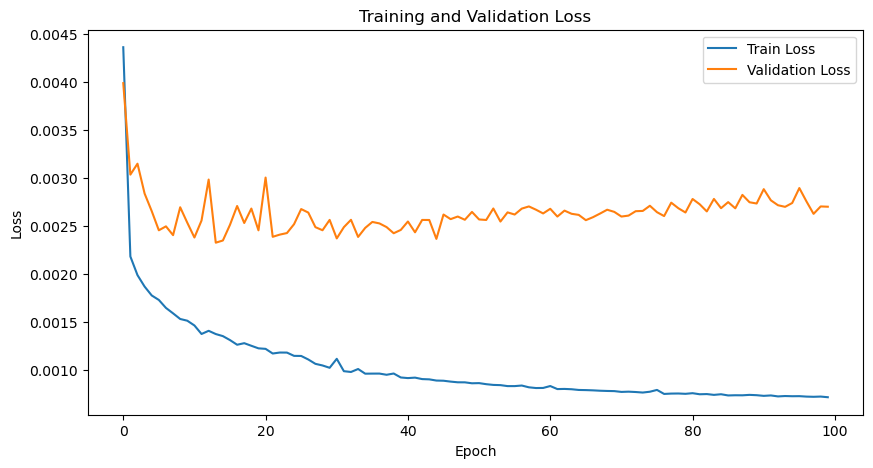

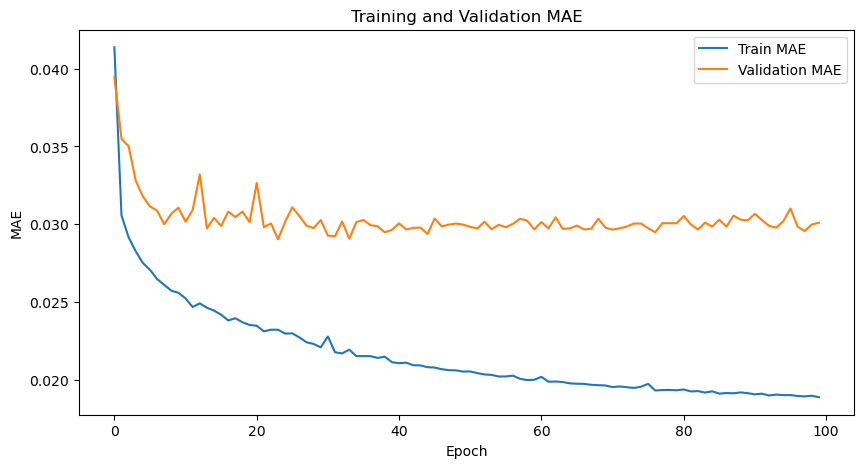

In [32]:
# Train for each cluster
for cluster, (X_train, future_train, y_train) in clusters_train_data.items():
    # Create DataLoader for training data
    train_dataset = TimeSeriesDataset(X_train, future_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) 

    val_X, val_future, val_y = clusters_val_data[cluster]

    # Create DataLoader for validation data
    val_dataset = TimeSeriesDataset(val_X, val_future, val_y)
    val_dataloader = DataLoader(val_dataset, batch_size=48, shuffle=False)

    print(f'Training for Cluster {cluster}')
    mlflow.start_run()
    train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=100)

# Prediction

In [33]:
def inverse_transform_predictions(predictions, cluster):
    """
    Inverse transform predictions using the scaler for the given cluster.
    predictions: numpy array of shape (num_samples, 2) containing predictions for Starts and Ends.
    cluster: the cluster ID to retrieve the corresponding scaler.
    """
    # Reshape predictions to match the scaler's expected input shape
    predictions = predictions.reshape(-1, 2)  # Ensure predictions are in shape (num_samples, 2)
    
    # Create a dummy array for the other features (excluding Starts and Ends)
    num_samples = predictions.shape[0]
    num_features = scalers[cluster].n_features_in_  # Total number of features used during fitting
    dummy_features = np.zeros((num_samples, num_features - 2))  # Exclude Starts and Ends
    
    # Combine predictions and dummy features
    combined = np.hstack([predictions, dummy_features])
    
    # Inverse transform the combined array
    original_scale_predictions = scalers[cluster].inverse_transform(combined)
    
    # Extract only the Starts and Ends columns
    original_scale_predictions = original_scale_predictions[:, :2]
    
    return original_scale_predictions

In [34]:
def predict(model, dataloader):
    model.eval()
    
    all_preds = []
    all_true = []

    with torch.no_grad():
    # Get a batch of validation data
    
        for batch_X, batch_future, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_future = batch_future.to(device)
            batch_y = batch_y.to(device)

            # Make predictions
            predictions = model(batch_X, batch_future).cpu().numpy()
            
            # Reshape predictions to (batch_size, pred_length, 2)
            predictions = predictions.reshape(-1, pred_length, 2)
            
            # Inverse transform predictions
            original_scale_predictions = []
            for i in range(predictions.shape[0]):
                pred = inverse_transform_predictions(predictions[i], cluster)
                original_scale_predictions.append(pred)
            original_scale_predictions = np.array(original_scale_predictions)
            
            # Inverse transform the true values (batch_y)
            original_scale_true = []
            for i in range(batch_y.shape[0]):
                true = inverse_transform_predictions(batch_y[i].cpu().numpy(), cluster)
                original_scale_true.append(true)
            original_scale_true = np.array(original_scale_true)

            all_preds.append(original_scale_predictions)
            all_true.append(original_scale_true)
    
    all_true = np.vstack(all_true)
    all_preds = np.vstack(all_preds)

    all_true_reshaped = all_true.reshape(-1, all_true.shape[-1])  # (6625 * 48, 2)
    all_preds_reshaped = all_preds.reshape(-1, all_preds.shape[-1])  # (6625 * 48, 2)

    mae = mean_absolute_error(all_true_reshaped, all_preds_reshaped)
    mse = mean_squared_error(all_true_reshaped, all_preds_reshaped)
    rmse = np.sqrt(mse)
    #smape = np.mean(np.abs((all_true_reshaped - all_preds_reshaped) / ((all_true_reshaped + all_preds_reshaped) / 2))) * 100

    # Save predictions
    np.save("true_values.npy", all_true)
    np.save("predictions.npy", all_preds)

    # Log to MLflow
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    
    mlflow.log_artifact("true_values.npy")
    mlflow.log_artifact("predictions.npy")

    print(f"Logged Metrics -> MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    print("Logged full dataset predictions to MLflow")

    return(all_preds, all_true)

In [35]:
cluster = 0
val_X, val_future, val_y = clusters_val_data[cluster]

# Create DataLoader for validation data
val_dataset = TimeSeriesDataset(val_X, val_future, val_y)
val_dataloader = DataLoader(val_dataset, batch_size=48, shuffle=False)

all_preds, all_true = predict(model, val_dataloader)
mlflow.end_run()

Logged Metrics -> MAE: 9.4947, MSE: 262.0488, RMSE: 16.1879
Logged full dataset predictions to MLflow


In [36]:
all_preds[0]

array([[ 5.11739360e+00, -1.34133205e-01],
       [ 8.57242478e+00,  2.87029856e+00],
       [ 5.65343355e+00,  3.87740025e+00],
       [ 3.13337617e+00,  3.04140100e+00],
       [ 4.68223353e+00,  2.60124621e+00],
       [ 3.67267985e+00,  4.80273632e+00],
       [ 4.08390024e+00,  5.12511802e+00],
       [ 3.65609342e+00,  4.64390396e+00],
       [ 3.92045815e+00,  4.65785064e+00],
       [ 2.00811461e+00,  4.27837017e+00],
       [ 2.13393770e+00,  2.13927363e+00],
       [-2.15975732e-01,  4.20711917e+00],
       [ 1.09079141e+01,  9.13106582e+00],
       [ 4.13281958e+01,  2.19892260e+01],
       [ 6.29425725e+01,  4.02331025e+01],
       [ 1.37546485e+02,  7.68439725e+01],
       [ 1.96613293e+02,  1.19390383e+02],
       [ 1.99728568e+02,  1.79775661e+02],
       [ 1.23067961e+02,  1.57816410e+02],
       [ 6.88012467e+01,  9.95697341e+01],
       [ 4.83851251e+01,  6.52029208e+01],
       [ 4.18558250e+01,  5.21033947e+01],
       [ 3.41306008e+01,  4.74211474e+01],
       [ 3.

In [37]:
original_scale_true = all_true
original_scale_predictions = all_preds

In [38]:
# Extract true and predicted values for Starts and Ends
true_starts = original_scale_true[:, :, 0]  # Shape: (batch_size, pred_length)
true_ends = original_scale_true[:, :, 1]    # Shape: (batch_size, pred_length)
pred_starts = original_scale_predictions[:, :, 0]  # Shape: (batch_size, pred_length)
pred_ends = original_scale_predictions[:, :, 1]    # Shape: (batch_size, pred_length)

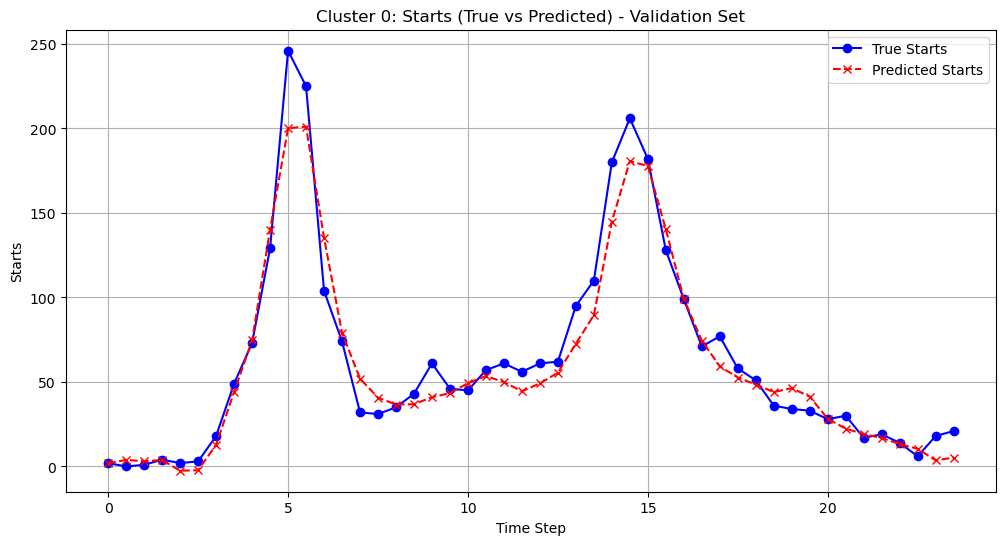

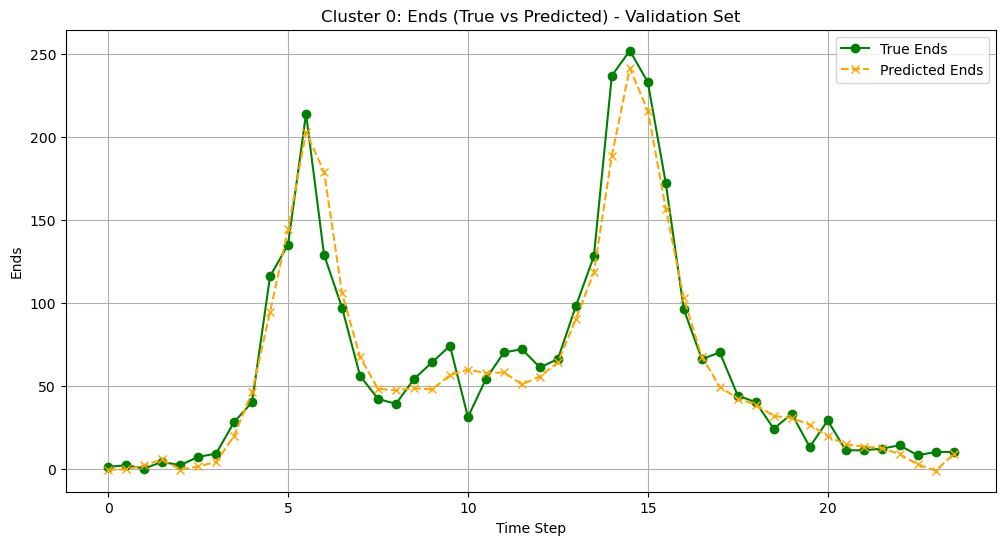

In [39]:
index = 6

# Plot Starts for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), true_starts[index], label="True Starts", color="blue", marker="o")
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), pred_starts[index], label="Predicted Starts", color="red", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Starts (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Starts")
plt.legend()
plt.grid(True)
plt.show()

# Plot Ends for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), true_ends[index], label="True Ends", color="green", marker="o")
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), pred_ends[index], label="Predicted Ends", color="orange", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Ends (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Ends")
plt.legend()
plt.grid(True)
plt.show()